In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)
pd.set_option("display.precision", 3)
pd.set_option('display.float_format', lambda x: '%.1f' % x)

## Context, Goals, and Methodologies

Sunny Futures STEM is an organization which wishes to create long-term improvement in the lives of underprivileged kids, by exposing them to exciting science events and getting them interested in STEM. They are looking for the best location to host their events in NYC such that it will reach the maximum number of at-risk kids. 

The goal is to provide recommendations as to the ideal location to place a STEM outreach event, such that it would reach and benefit the maximum number of at-risk students.

We accomplished this by obtaining and analyzing NYC Department of Education school performance data to identify the highest-risk and worst-performing schools in NYC, and obtaining, cleaning, and analyzing MTA turnstile data to look at city subway station foot traffic. We used Google Maps to locate the at-risk schools and their nearest subway stations, and the cleaned MTA data to analyze afternoon weekday ridership at stations nearby schools, to determine at which of these stations there is the most student foot-traffic to see the demonstrations. 

## Obtaining MTA Turnstile Data

Loading in data, we selected datasets for Sept 7th to Dec 7th, 2019, respresenting the fall semester for NYC public schools:

In [2]:
# Source: http://web.mta.info/developers/turnstile.html
def get_data(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs)
        
# weeks: sept 7th to december 7th, 2019    
week_nums = [190907, 190914, 190921, 190928, 191005, 191012, 191019,
            191026, 191102, 191109, 191116, 191123, 191130, 191207]
df = get_data(week_nums)

## Cleaning MTA Data

Creating a DATETIME column, and replacing DATE and TIME columns' entries (currently, 'object' types) with 'datetime objects', so we could analyze trends over days, weeks, and times of day:

In [3]:
df.shape

(2882165, 11)

In [4]:
df["DATETIME"] = pd.to_datetime(df["DATE"] + " " + df["TIME"], format="%m/%d/%Y %H:%M:%S")

In [5]:
df["DATE"] = pd.to_datetime(df["DATE"], format="%m/%d/%Y")
df["TIME"] = pd.to_datetime(df["TIME"])

Cleaning up column name for EXIT column, which had many trailing spaces: 

In [6]:
df.rename(columns={'EXITS                                                               ':"EXITS"}, inplace=True)

Next, we had to find the actual entries and exits for each row because the entry/exit counters record a cumulative running total, instead of independent counts for each (typically) 4 hour time period.  We found the actual number of entries by finding the difference between each entry/exit 'total count' value and the value that precedes it, for each turnstile. 
 We are filtering by C/A, UNIT, and SCP, since those 3 descriptors together define a single turnstile:

In [7]:
df.reset_index(inplace=True)
df.head()

,index,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME
0,0,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-08-31,2020-07-05 00:00:00,REGULAR,7183242,2433142,2019-08-31 00:00:00
1,1,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-08-31,2020-07-05 04:00:00,REGULAR,7183258,2433149,2019-08-31 04:00:00
2,2,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-08-31,2020-07-05 08:00:00,REGULAR,7183278,2433176,2019-08-31 08:00:00
3,3,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-08-31,2020-07-05 12:00:00,REGULAR,7183393,2433262,2019-08-31 12:00:00
4,4,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-08-31,2020-07-05 16:00:00,REGULAR,7183572,2433312,2019-08-31 16:00:00


In [8]:
real_entries = df.groupby(["C/A", "UNIT", "SCP"]).agg({"ENTRIES": "diff"})
real_exits = df.groupby(["C/A", "UNIT", "SCP"]).agg({"EXITS": "diff"})

> The above used pandas "diff" as aggregating function. From pandas documention: "Calculates the difference of a DataFrame element compared with another element in the DataFrame (default is the element in the same column of the previous row)." This is exactly what we wanted to do. We broke it up into each individual unit first, becuase we only want it to subtract from entry/exit data for its own turnstile. therefore, first values for each turnstile, with nothing to subtract from (no preceding value), return NaN.

Adding new columns for actual entries and exits to the DataFrame:

In [9]:
df["REAL_ENTRIES"] = real_entries["ENTRIES"]
df["REAL_EXITS"] = real_exits["EXITS"]
df.head()

,index,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME,REAL_ENTRIES,REAL_EXITS
0,0,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-08-31,2020-07-05 00:00:00,REGULAR,7183242,2433142,2019-08-31 00:00:00,nan,nan
1,1,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-08-31,2020-07-05 04:00:00,REGULAR,7183258,2433149,2019-08-31 04:00:00,16.0,7.0
2,2,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-08-31,2020-07-05 08:00:00,REGULAR,7183278,2433176,2019-08-31 08:00:00,20.0,27.0
3,3,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-08-31,2020-07-05 12:00:00,REGULAR,7183393,2433262,2019-08-31 12:00:00,115.0,86.0
4,4,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-08-31,2020-07-05 16:00:00,REGULAR,7183572,2433312,2019-08-31 16:00:00,179.0,50.0


Exploring the new real traffic data: there are many values which appear that are erroneous -- some which are extremely large and not possibly representative of real entries or exits in a 4-hour period, and some which are negative. Both types are likely caused by turnstile errors or resets and the way we calculated our real entries and exits -- if subtracting a newly reset counter from a previously very high counter, for example, doesn't yield a true difference in how many riders entered during that time period, but instead gives a large negative number. Such entries need to be removed. Examples of the most extemely erroneous data are included below: 

In [10]:
df["REAL_ENTRIES"].sort_values(ascending=False).head(10)

2440547   2037956058.0
2027192   1754729527.0
1402753   1704548686.0
2027234   1554189845.0
1157898    730710276.0
1157894    730710263.0
1157896    730710262.0
1157892    730710255.0
1157890    730710208.0
73163      718560745.0
Name: REAL_ENTRIES, dtype: float64

In [11]:
df["REAL_EXITS"].sort_values(ascending=False).head(10)

73163     1886405893.0
1402753   1019395842.0
2440547    902456873.0
366070     568618937.0
1408555    300790885.0
1815960    267405278.0
2027192    150359755.0
2027234    133731198.0
1744346    100844994.0
1616439    100304985.0
Name: REAL_EXITS, dtype: float64

In [12]:
df["REAL_ENTRIES"].sort_values().head(10)

1068802   -2025847485.0
792556    -2013355772.0
1204647   -1186521378.0
1068768   -1121336461.0
386825     -991539584.0
1157895    -730710262.0
1157897    -730710254.0
1157893    -730710240.0
1157899    -730710220.0
1157891    -730710088.0
Name: REAL_ENTRIES, dtype: float64

In [13]:
df["REAL_EXITS"].sort_values().head(10)

1068768   -1907466468.0
1204647    -885740374.0
792556     -839005509.0
1397682    -721823991.0
436975     -701914974.0
1068802    -622024878.0
386825     -504187450.0
2024480     -50412910.0
742744      -50330882.0
207269      -20876713.0
Name: REAL_EXITS, dtype: float64

First, removing the negative and NaN values from the data, knowing that this will remove the entire row which contains the error:

In [14]:
df = df.loc[df["REAL_ENTRIES"] >= 0]
df = df.loc[df["REAL_EXITS"] >= 0]

In [15]:
df.shape

(2843278, 15)

So far, this has removed about 80,000 data points, which constitues only 2.5% of the total data. We have decided it is appropriate to remove this amount of data, since it not only comprises a very small percentage, but also because including the data would be more skewing to our results (since the values are so incorrect) than would simply removing them. 

Now, we want to remove the very large values -- practically, we want to eliminate entry/exit data which is abnormal for its specific turnstile/station. Some values (2000, e.g.) may be very normal for certain stations (like Times Square), but may be highly irregular for another station. If we define a cutoff threshhold above some general number for all of the data, that would allow 2000 to stay; but if a turnstile's average 4-hour ridership is only 15 people, a value of 2000 should in fact be removed and indicates an error (or, at best, a one-time anomalous event which we don't need to base our average values on anyway). It is for this reason that an arbitrary cut off value should not be chosen for the entire dataset, but rather averages for each station should inform that stations individual cutoff value for an unrealistic/error entry to be removed. 

To do this first requires finding average 4-hour (single-row) ridership values for each station. We are grouping by both STATION and LINENAME because we discovered that multiple stations have the same name, but are in fact separate (though nearby) and service different lines. Therefore it is the combination of STATION and LINENAME which comprise a single station. We are also using median over mean as our determination of 'average' ridership, because median values will be less skewed by the presence of extremely large error numbers. 

In [16]:
station_averages = df.groupby(["STATION", "LINENAME"])[["REAL_ENTRIES", "REAL_EXITS"]].median()
station_averages.reset_index(inplace=True)

In [17]:
station_averages.rename(columns={"REAL_ENTRIES":"AVERAGE_ENTRIES"}, inplace=True)
station_averages.rename(columns={"REAL_EXITS":"AVERAGE_EXITS"}, inplace=True)

Adding columns for average values into main DataFrame: 

In [18]:
df = pd.merge(left=df, right=station_averages, left_on=["STATION", "LINENAME"], right_on=["STATION", "LINENAME"])

Now, using average values to filter out any single 4-hour entry with ridership greater than 100 times the average for that station. This will remove error values and also even if it removes a real value, if there was a surge of 2 orders of magnitude above normal, it is probably a standalone event that doesn't help inform our data.

In [19]:
df = df.loc[df["REAL_ENTRIES"] < 100*df["AVERAGE_ENTRIES"]]
df = df.loc[df["REAL_EXITS"] < 100*df["AVERAGE_EXITS"]]

In [20]:
df.shape

(2762803, 17)

After the removal of these high positive values, we have lost only about 4% of the data total. Many of those lost were NaN values which weren't data to begin with, and this is still a very small and tolerable percentage of data to lose. 

Now in observing the highest entry values, they are of normal and expected magnitude, with only 3 exceptions at the top: 

In [21]:
df["REAL_ENTRIES"].sort_values(ascending=False).head(10)

367310    14832.0
367267    10233.0
1256340    5968.0
1652732    5204.0
833191     5137.0
335157     4830.0
833233     4426.0
1257520    4399.0
2221917    4308.0
1652721    4270.0
Name: REAL_ENTRIES, dtype: float64

In [22]:
df["REAL_EXITS"].sort_values(ascending=False).head(10)

1999665   15980.0
367310     7693.0
367267     7636.0
833275     6624.0
43561      5598.0
1945522    5203.0
334899     5184.0
778290     5097.0
778339     5064.0
774996     5005.0
Name: REAL_EXITS, dtype: float64

## Analyzing MTA Data

### Analysis of busiest station to verify accuracy of cleaning methods

Now that the data is cleaned, we can combine entries and exits into a single value representative of the total traffic at that station in a given time frame:

In [23]:
df["TRAFFIC"] = df["REAL_ENTRIES"] + df["REAL_EXITS"]

Now we can group the data in various ways analyze it. We will start by looking at the total traffic at each station in this 3 month period, to find out which stations are the busiest: 

In [24]:
total_station_traffic = df.groupby(["STATION", "LINENAME"])[["TRAFFIC"]].sum()
total_station_traffic.reset_index(inplace=True)

Finding busiest stations by total traffic to check the accuracy of our data analysis:

In [25]:
total_station_traffic.sort_values(by="TRAFFIC", ascending=False).head(20)

,STATION,LINENAME,TRAFFIC
310,GRD CNTRL-42 ST,4567S,22706169.0
88,34 ST-HERALD SQ,BDFMNQRW,19936316.0
92,34 ST-PENN STA,ACE,13653526.0
101,42 ST-PORT AUTH,ACENQRS1237W,12353636.0
28,14 ST-UNION SQ,LNQR456W,11583395.0
441,TIMES SQ-42 ST,1237ACENQRSW,10921827.0
105,47-50 STS ROCK,BDFM,10440520.0
300,FULTON ST,2345ACJZ,10056623.0
124,59 ST COLUMBUS,ABCD1,9842010.0
287,FLUSHING-MAIN,7,9091166.0


![top 10](https://imgur.com/a/Z7wcPJA)

Verifying the top busiest stations against actual busiest stations in 2019 (above) to verify accuracy of our filtered data, our data analysis has proved correct. The busiest 10 are all within our busiest top 20, and this is only for three months's worth of data which may have discrepencies from the yearly total. Excellent! Now we can move forward with further analysis after confirming the accuracy of how we've handled the data thus far. 

### Analysis of traffic relevant to student commute

Now, to focus on what the client needs. Sunny Futures STEM is looking for the ideal locations to hold science outreach events, that will have the most exposure to kids in underprivelaged areas, in order to get them excited about STEM and benefit their future. 

Our plan is to send Sunny Futures to subway stations located closest to underachieving schools so that kids on their commute home from those schools will get to see the demonstrations. For this reason, we must find which schools have the most need, which stations are the closest to those schools, and which of those stations have the highest ridership, such that the STEM outreach event can be placed strategically to get the most traffic. 

First of all, students will only be commuting in the afternoon. In order to make sure we are analyzing station traffic that is more representative of student commute and less of post-workday adult commute, we can filter the data to include only traffic taking place in the early afternoon (1pm to 4:15pm):

In [26]:
by_datetime = df.set_index("DATETIME")
afternoon_traffic = by_datetime.between_time("01:00:00", "04:15:00")
afternoon_traffic

,index,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,REAL_ENTRIES,REAL_EXITS,AVERAGE_ENTRIES,AVERAGE_EXITS,TRAFFIC
DATETIME,,,,,,,,,,,,,,,,,
2019-08-31 04:00:00,1,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-08-31,2020-07-05 04:00:00,REGULAR,7183258,2433149,16.0,7.0,93.0,20.0,23.0
2019-09-01 04:00:00,7,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-09-01,2020-07-05 04:00:00,REGULAR,7184025,2433380,17.0,4.0,93.0,20.0,21.0
2019-09-02 04:00:00,13,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-09-02,2020-07-05 04:00:00,REGULAR,7184669,2433541,9.0,4.0,93.0,20.0,13.0
2019-09-03 04:00:00,19,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-09-03,2020-07-05 04:00:00,REGULAR,7185240,2433721,6.0,3.0,93.0,20.0,9.0
2019-09-04 04:00:00,25,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-09-04,2020-07-05 04:00:00,REGULAR,7186520,2434092,11.0,5.0,93.0,20.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-02 04:00:00,205895,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,2019-12-02,2020-07-05 04:00:00,REGULAR,5554,420,0.0,0.0,15.0,1.0,0.0
2019-12-03 04:00:00,205901,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,2019-12-03,2020-07-05 04:00:00,REGULAR,5554,420,0.0,0.0,15.0,1.0,0.0
2019-12-04 04:00:00,205907,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,2019-12-04,2020-07-05 04:00:00,REGULAR,5554,420,0.0,0.0,15.0,1.0,0.0


To observe the effect this had: 

In [27]:
total_afternoon_traffic = afternoon_traffic.groupby(["STATION", "LINENAME"])[["TRAFFIC"]].sum()
total_afternoon_traffic.reset_index(inplace=True)
total_afternoon_traffic.rename(columns={"TRAFFIC": "AFTERNOON TRAFFIC"}, inplace=True)

In [28]:
total_afternoon_traffic["ALL TRAFFIC"] = total_station_traffic["TRAFFIC"]
total_afternoon_traffic["RATIO"] = total_afternoon_traffic["AFTERNOON TRAFFIC"] / total_afternoon_traffic["ALL TRAFFIC"]
total_afternoon_traffic

,STATION,LINENAME,AFTERNOON TRAFFIC,ALL TRAFFIC,RATIO
0,1 AV,L,73679.0,2961144.0,0.0
1,103 ST,1,113262.0,1611777.0,0.1
2,103 ST,6,125881.0,2197724.0,0.1
3,103 ST,BC,47353.0,708476.0,0.1
4,103 ST-CORONA,7,138719.0,3147799.0,0.0
...,...,...,...,...,...
465,WOODLAWN,4,26001.0,741232.0,0.0
466,WORLD TRADE CTR,ACE23,33210.0,2732787.0,0.0
467,WTC-CORTLANDT,1,84799.0,1917343.0,0.0
468,YORK ST,F,92890.0,1675447.0,0.1


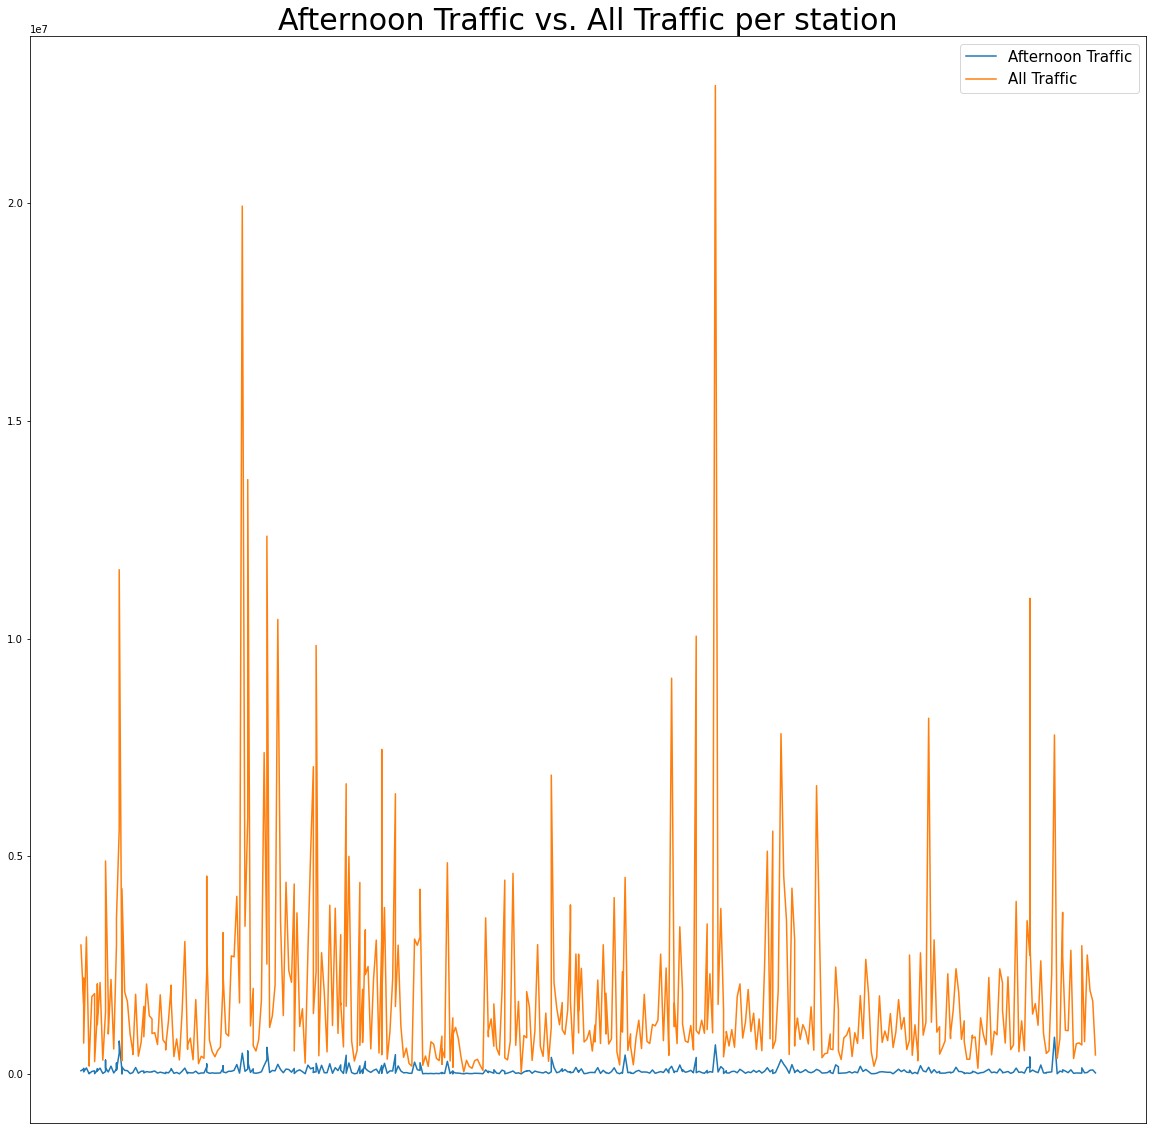

In [30]:
plt.figure(figsize=[20, 20])
plt.plot(total_afternoon_traffic["STATION"], total_afternoon_traffic["AFTERNOON TRAFFIC"])
plt.plot(total_afternoon_traffic["STATION"], total_afternoon_traffic["ALL TRAFFIC"])
plt.legend(["Afternoon Traffic", "All Traffic"], fontsize=15)
plt.xticks([])
plt.title("Afternoon Traffic vs. All Traffic per station", fontsize=30);

In [31]:
total_afternoon_traffic["RATIO"].mean()

0.04313499700887999

This demonstrates that the effect of selecting only afternoon data vs. all traffic data is significant! Afternoon traffic comprises only an average of 4.3% of total traffic, so it's important to use only this selection when looking at student commutes. This helps filter out commuting workers, tourists going out in the evenings, etc. from informing us which stations would have the most student commuters. 

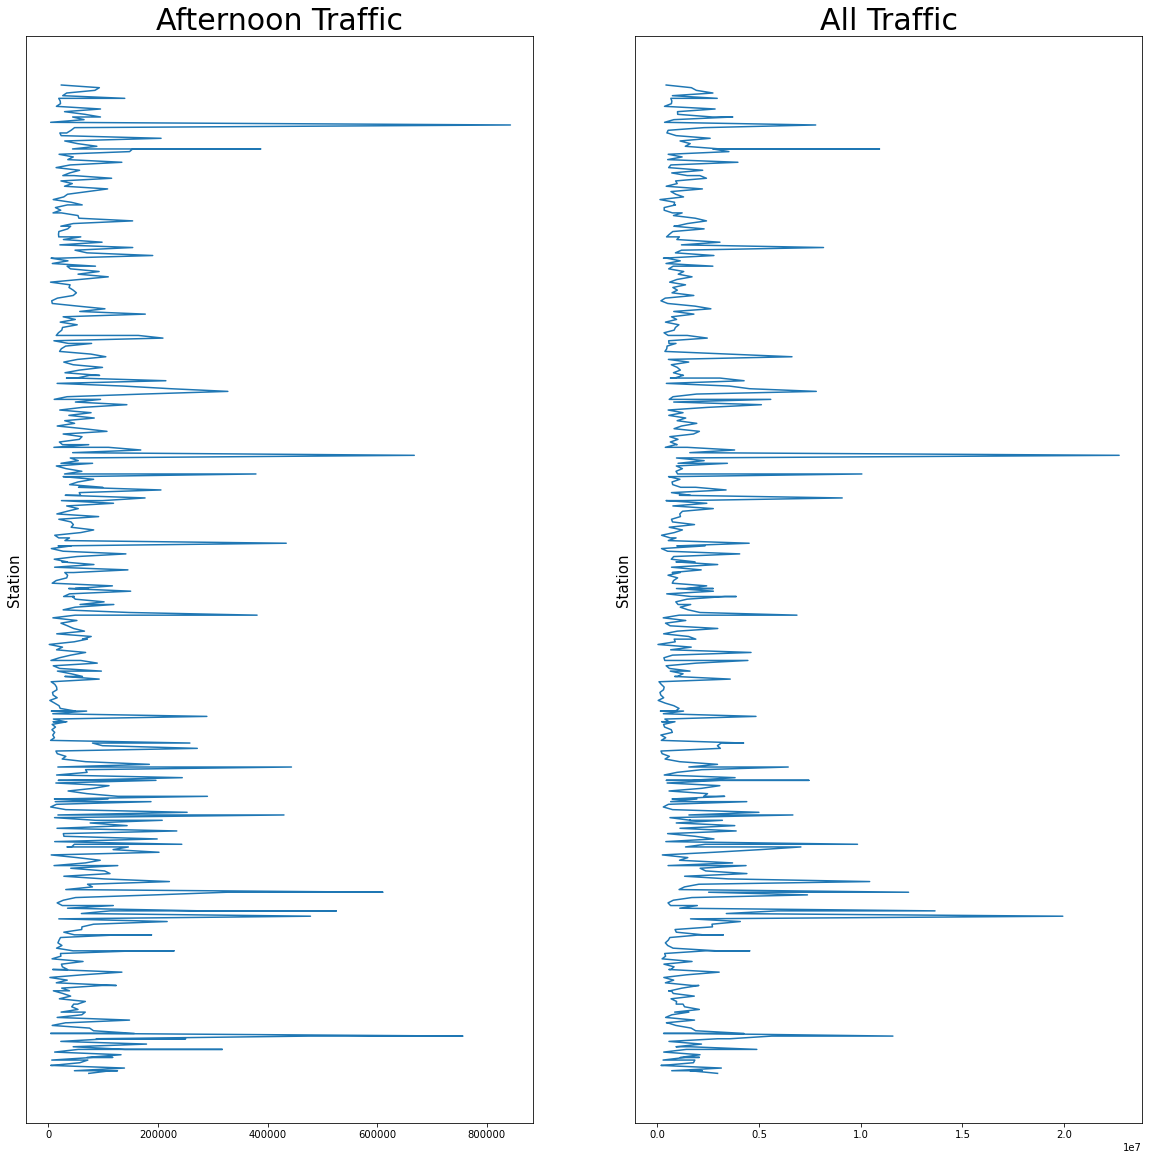

In [32]:
plt.figure(figsize=[20, 20])
plt.subplot(1, 2, 1)
plt.plot(total_afternoon_traffic["AFTERNOON TRAFFIC"], total_afternoon_traffic["STATION"])
plt.title("Afternoon Traffic", fontsize=30)
plt.yticks([])
plt.ylabel("Station", fontsize=15)

plt.subplot(1, 2, 2)
plt.plot(total_afternoon_traffic["ALL TRAFFIC"], total_afternoon_traffic["STATION"])
plt.title("All Traffic", fontsize=30)
plt.yticks([])
plt.ylabel("Station", fontsize=15);

Interestingly, as seen above, the trend across stations is actually quite similar for just afternoon traffic as it is for all traffic. Stations that are always busy are still busier in the afternoon in comparison to stations that are not. Just the magnitude is different. 

Still, there do exist differences, and as seen by the x-values on the bottom of each of the above graphs, the number of commuters is vastly different. Since we want to know only about student commuters, and we want the most accurate data about them, we will move forward with analyzing only afternoon traffic. 

Secondly, students will of course only be commuting on weekdays, so we can filter out weekend data from our afternoon station traffic totals: 

In [33]:
daily_traffic = afternoon_traffic.groupby(["STATION", "LINENAME", "DATE"])[["TRAFFIC"]].sum()
daily_traffic.reset_index(inplace=True)

In [34]:
daily_traffic["DAY"] = daily_traffic["DATE"].dt.day_name()
daily_traffic["DAY_ALIAS"] = daily_traffic["DATE"].dt.dayofweek

In [35]:
daily_weekday_traffic = daily_traffic[daily_traffic["DAY_ALIAS"] < 5]

Graphing daily total traffic over the 3 month period (to see which days would be most advantageous to set up the demos) demonstrates that later weekdays have the highest afternoon traffic. Although Friday has the highest traffic, Wednesday or Thursday would be better choices - students are still in the middle of the school week and thus more likely to stop and engage with our science fair demos, rather than running off to their weekend; also, the traffic numbers are nearly as high on Weds/Thurs as they are on Friday, but more likely to include solely students commuting and not weekend tourists in the area:

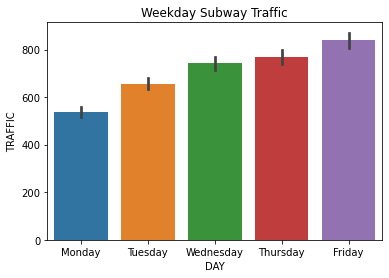

In [182]:
sns.barplot(x="DAY", y="TRAFFIC", data=daily_weekday_traffic).set_title("Weekday Subway Traffic");

Now, finding total traffic at each station during this 3 month period as above, but summing over weekday afternoon traffic only:

In [37]:
total_station_traffic_weekday_afternoons = daily_weekday_traffic.groupby(["STATION", "LINENAME"])[["TRAFFIC"]].sum()
total_station_traffic_weekday_afternoons.reset_index(inplace=True)
total_station_traffic_weekday_afternoons

,STATION,LINENAME,TRAFFIC
0,1 AV,L,38513.0
1,103 ST,1,74665.0
2,103 ST,6,84607.0
3,103 ST,BC,30004.0
4,103 ST-CORONA,7,92987.0
...,...,...,...
465,WOODLAWN,4,17038.0
466,WORLD TRADE CTR,ACE23,23190.0
467,WTC-CORTLANDT,1,56721.0
468,YORK ST,F,59548.0


With the DataFrame above, we have traffic information for weekday afternoon business for each stations, summed over the fall semester, which will help inform our outreach location recommendation. 

## Obtaining and Analyzing School Performance Data

Next, we need to identify which schools in NYC are underachieving, whose students would be in the most need of some inspiration towards a STEM future. To do this, we read in an excel file from the NYC Department of Education's InfoHub, which contained ratings for every elementary, middle and k-8 school across a wide range of metrics. 

The metrics we determined as most relevant indicators of need and under-performance were "Student Achievement Rating" and "Economic Need Index". Here we read in the excel file of information, clean up the column names, filter by those metrics, and display the School Data Frame with the 20 most underachieving schools in New York City by those standards: 

In [38]:
pd.set_option("display.max_columns", None)

column_names = ['1', '2', '3', 'DBN', 'School Name', 'School Type', 'Enrollment', 'Rigorous Instruction Rating', 'Collaborative Teachers Rating', 'Supportive Environment Rating', 'Effective School Leadership Rating', 'Strong Family-Community Ties Rating', 'Trust Rating', 'Student Achievement Rating', 'Rigorous Instruction-Percent Positive', 'Collaborative Teachers-Percent Positive', 'Supportive Environment-Percent Positive', 'Effective School Leadership-Percent Positive', 'Strong Family-Community Ties-Percent Positive', 'Trust-Percent Positive', 'Quality Review-Interesting/Challenging Curriculum?', 'Quality Review-Effectiveness of Teaching and Learning', 'Quality Review- How Well School Assesses Student Learning', 'Quality Review-High Expectations Communicated Clearly?', 'Quality Review-How Well Do Teachers Work Together?', 'Quality Review-How Safe & Inclusive is School?', 'Quality Review- How Well School Allocates/Manages Resources', 'Quality Review-How Well School Identify/Track/Meet Goals', 'Quality Review- How Thoughtful is School\'s Approach to Teacher Development/Evaluation', 'Quality Review- How Well School Decisions Evaluated/Adjusted?', 'Quality Review- Dates of Review', 'Average Incoming ELA Proficiency (Based on 5th Grade)', 'Average Incoming Math Proficiency (Based on 5th Grade)', 'Percent English Language Learners', 'Percent Students w/ Disabilities', 'Percent Self-Contained', 'Economic Need Index', 'Percent in Temp Housing', 'Percent HRA Eligible', 'Percent Asian', 'Percent Black', 'Percent Hispanic', 'Percent White', 'Years of Principal Experience @ School', 'Percent of Teachers w/ 3 or More Years Experience', 'Student Attendance Rate', 'Percent of Students Chronically Absent', 'Teacher Attendance Rate']
elementary_data = pd.read_excel(r'https://infohub.nyced.org/docs/default-source/default-document-library/201819_ems_sqr_results.xlsx', names=column_names)
elementary_data.drop(elementary_data.index[:4], inplace=True)
elementary_data.drop(columns=['1', '2', '3'], inplace=True)
elementary_data.dropna(how='any', inplace=True)
not_meeting_target_achievement = elementary_data[elementary_data['Student Achievement Rating'] == 'Not Meeting Target']
at_risk_schools = (not_meeting_target_achievement[not_meeting_target_achievement['Economic Need Index'] > 0.7]).sort_values(by='Economic Need Index', ascending=False)
at_risk_schools.head(20)

,DBN,School Name,School Type,Enrollment,Rigorous Instruction Rating,Collaborative Teachers Rating,Supportive Environment Rating,Effective School Leadership Rating,Strong Family-Community Ties Rating,Trust Rating,Student Achievement Rating,Rigorous Instruction-Percent Positive,Collaborative Teachers-Percent Positive,Supportive Environment-Percent Positive,Effective School Leadership-Percent Positive,Strong Family-Community Ties-Percent Positive,Trust-Percent Positive,Quality Review-Interesting/Challenging Curriculum?,Quality Review-Effectiveness of Teaching and Learning,Quality Review- How Well School Assesses Student Learning,Quality Review-High Expectations Communicated Clearly?,Quality Review-How Well Do Teachers Work Together?,Quality Review-How Safe & Inclusive is School?,Quality Review- How Well School Allocates/Manages Resources,Quality Review-How Well School Identify/Track/Meet Goals,Quality Review- How Thoughtful is School's Approach to Teacher Development/Evaluation,Quality Review- How Well School Decisions Evaluated/Adjusted?,Quality Review- Dates of Review,Average Incoming ELA Proficiency (Based on 5th Grade),Average Incoming Math Proficiency (Based on 5th Grade),Percent English Language Learners,Percent Students w/ Disabilities,Percent Self-Contained,Economic Need Index,Percent in Temp Housing,Percent HRA Eligible,Percent Asian,Percent Black,Percent Hispanic,Percent White,Years of Principal Experience @ School,Percent of Teachers w/ 3 or More Years Experience,Student Attendance Rate,Percent of Students Chronically Absent,Teacher Attendance Rate
296,09X350,New Directions Secondary School,Middle,81,Approaching Target,Approaching Target,Approaching Target,Approaching Target,Approaching Target,Approaching Target,Not Meeting Target,0.7,0.7,0.6,0.8,0.8,0.8,Proficient,Developing,Developing,Proficient,Proficient,Proficient,Proficient,Developing,Proficient,Proficient,April 2018,2.0,2.0,0.3,0.3,0.1,1.0,0.3,1.0,0.0,0.3,0.6,0.0,6.1,0.6,0.6,0.8,1.0
210,07X224,P.S./I.S. 224,Middle,328,Approaching Target,Not Meeting Target,Approaching Target,Approaching Target,Meeting Target,Approaching Target,Not Meeting Target,0.6,0.4,0.6,0.6,0.9,0.7,Proficient,Developing,Proficient,Proficient,Developing,Proficient,Proficient,Proficient,Proficient,Proficient,March 2017,2.1,2.4,0.2,0.3,0.1,1.0,0.3,0.9,0.0,0.3,0.7,0.0,0.1,0.7,0.9,0.4,0.9
145,05M194,P.S. 194 Countee Cullen,Elementary,183,Meeting Target,Meeting Target,Meeting Target,Meeting Target,Meeting Target,Approaching Target,Not Meeting Target,0.7,0.6,0.5,0.7,0.9,0.8,Proficient,Proficient,Proficient,Proficient,Proficient,Proficient,Proficient,Proficient,Well Developed,Proficient,May 2018,.,.,0.2,0.3,0.1,1.0,0.4,0.9,0.0,0.6,0.3,0.0,0.9,0.7,0.9,0.3,0.9
7,01M034,P.S. 034 Franklin D. Roosevelt,K-8,288,Approaching Target,Approaching Target,Approaching Target,Approaching Target,Meeting Target,Approaching Target,Not Meeting Target,0.7,0.7,0.6,0.7,0.9,0.8,Developing,Developing,Developing,Proficient,Proficient,Developing,Proficient,Proficient,Proficient,Developing,October 2017,.,.,0.1,0.4,0.0,0.9,0.3,0.9,0.0,0.3,0.6,0.0,2.7,0.5,0.9,0.5,1.0
641,19K663,School of the Future Brooklyn,Middle,193,Approaching Target,Approaching Target,Approaching Target,Approaching Target,Meeting Target,Approaching Target,Not Meeting Target,0.7,0.6,0.6,0.8,0.9,0.8,Developing,Developing,Developing,Developing,Developing,Proficient,Proficient,Developing,Proficient,Developing,May 2017,2.1,2.0,0.1,0.3,0.0,0.9,0.3,0.9,0.0,0.7,0.3,0.0,1.1,0.5,0.9,0.4,1.0
114,04M057,James Weldon Johnson,K-8,762,Approaching Target,Approaching Target,Approaching Target,Approaching Target,Approaching Target,Approaching Target,Not Meeting Target,0.6,0.6,0.6,0.5,0.9,0.7,Proficient,Proficient,Proficient,Proficient,Proficient,Proficient,Proficient,Proficient,Proficient,Proficient,February 2018,.,.,0.1,0.3,0.1,0.9,0.3,0.8,0.0,0.3,0.7,0.0,1.3,0.8,0.9,0.4,1.0
757,23K323,P.S./I.S. 323,K-8,548,Meeting Target,Meeting Target,Approaching Target,Meeting Target,Meet

Thus, the 20 most underachieving schools in NYC are: 

In [39]:
schools = at_risk_schools["School Name"]
schools = pd.DataFrame(schools)
schools

,School Name
296,New Directions Secondary School
210,P.S./I.S. 224
145,P.S. 194 Countee Cullen
7,P.S. 034 Franklin D. Roosevelt
641,School of the Future Brooklyn
114,James Weldon Johnson
757,P.S./I.S. 323
628,The Fresh Creek School
462,P.S. 287 Bailey K. Ashford
460,P.S. 270 Johann DeKalb


We then consulted Google Maps with this list of schools to find the locations of the schools, and which subway stations each school was nearest to, that the children would be using to commute. 

Notably, many of these at-risk schools were actually located nearby to one another, concentrated in 3 main neighborhoods. This was a key finding in our analysis. 

### Harlem: 

![map1](https://imgur.com/pegyZx7)

### East Brooklyn: 
![map2](https://imgur.com/DFHo3C2)

### and East Bronx: 
![map3](https://imgur.com/9WmFaje)

## Combining School and MTA Data

We manually found the closest stations to each school via Google Maps, then used the list of station names within the MTA data above to create a DataFrame with names of each school, and their closest 2 stations. (Note: only 1 station is included if the second closest is significantly farther away. Schools with the same station name repeated for both first and second closest are actually two distinct stations by the same name, which actually service different lines. More on this later):

In [40]:
df["STATION"].unique()

array(['59 ST', '5 AV/59 ST', '57 ST-7 AV', '49 ST', 'TIMES SQ-42 ST',
       '34 ST-HERALD SQ', '28 ST', '23 ST', '14 ST-UNION SQ', '8 ST-NYU',
       'PRINCE ST', 'CANAL ST', 'CITY HALL', 'CORTLANDT ST', 'RECTOR ST',
       'WHITEHALL S-FRY', 'DELANCEY/ESSEX', 'BOWERY', 'CHAMBERS ST',
       'FULTON ST', 'BROAD ST', '7 AV', 'PARK PLACE', 'BOTANIC GARDEN',
       'PROSPECT PARK', 'PARKSIDE AV', 'CHURCH AV', 'BEVERLEY ROAD',
       'CORTELYOU RD', 'NEWKIRK PLAZA', 'AVENUE H', 'AVENUE J',
       'AVENUE M', 'KINGS HWY', 'AVENUE U', 'NECK RD', 'SHEEPSHEAD BAY',
       'BRIGHTON BEACH', 'OCEAN PKWY', 'BOROUGH HALL', 'JAY ST-METROTEC',
       'DEKALB AV', 'ATL AV-BARCLAY', 'UNION ST', '4AV-9 ST',
       'PROSPECT AV', '25 ST', '36 ST', '45 ST', '53 ST', 'BAY RIDGE AV',
       '77 ST', '86 ST', 'BAY RIDGE-95 ST', '8 AV', 'FT HAMILTON PKY',
       'NEW UTRECHT AV', '18 AV', '20 AV', 'BAY PKWY', '9 AV', '50 ST',
       '55 ST', '71 ST', '79 ST', '25 AV', 'BAY 50 ST', 'CONEY IS-STILLW',
      

In [41]:
schools.index

Int64Index([296, 210, 145,   7, 641, 114, 757, 628, 462, 460, 577, 321, 580,
             94, 377, 154, 372, 737, 965, 963, 970,  89, 962, 602],
           dtype='int64')

In [120]:
nearest_stations = {296: ("170 ST", "N/A"), 210: ("BROOK AV", "3 AV-149 ST"), 145: ("145 ST", "145 ST"), 7: ("1 AV", "N/A"), 641: ("LIVONIA AV", "PENNSYLVANIA AV"), 114: ("116 ST", "N/A"), 757: ("ROCKAWAY AV", "N/A"), 628: ("EAST 105 ST", "NEW LOTS AV"), 462: ("YORK ST", "N/A"), 460: ("CLASSON AV", "N/A"), 577: ("UTICA AV", "N/A"), 321: ("42 ST-PORT AUTH", "N/A"), 580: ("CHURCH AV", "BEVERLEY ROAD"), 94: ("125 ST", "125 ST"), 377: ("PELHAM PKWY", "ALLERTON AV"), 154: ("135 ST", "135 ST"), 372: ("BURKE AV", "N/A"), 737: "not close to subway", 965: "not close to subway", 963: "not close to subway", 970: "not close to subway", 89: ("125 ST", "116 ST"), 962: "not close to subway", 602: "not close to subway"}  
nearest_stations = pd.DataFrame(nearest_stations).transpose()

In [121]:
schools_stations = pd.concat([schools, nearest_stations], axis=1)
schools_stations.rename(columns={0: "Nearest Station"}, inplace=True)
schools_stations.rename(columns={1: "Second Nearest Station"}, inplace=True)

Since some schools are not near any subways, they will not have as much nearby foot traffic to come to the science demonstrations, so we can remove those from the dataframe: 

In [122]:
schools_stations = schools_stations.loc[schools_stations["Nearest Station"] != "not close to subway"]
schools_stations

,School Name,Nearest Station,Second Nearest Station
296,New Directions Secondary School,170 ST,N/A
210,P.S./I.S. 224,BROOK AV,3 AV-149 ST
145,P.S. 194 Countee Cullen,145 ST,145 ST
7,P.S. 034 Franklin D. Roosevelt,1 AV,N/A
641,School of the Future Brooklyn,LIVONIA AV,PENNSYLVANIA AV
114,James Weldon Johnson,116 ST,N/A
757,P.S./I.S. 323,ROCKAWAY AV,N/A
628,The Fresh Creek School,EAST 105 ST,NEW LOTS AV
462,P.S. 287 Bailey K. Ashford,YORK ST,N/A
460,P.S. 270 Johann DeKalb,CLASSON AV,N/A


Grouping the above dataframe into the 3 respective regions of highest concentration of schools with close proximity (note, "other" is used when the school is isolated and not near any other schools):

In [123]:
neighborhood = {296: "other", 210: "Harlem", 145: "Harlem", 7: "other", 641: "East Brooklyn", 114: "Harlem", 757: "East Brooklyn", 628: "East Brooklyn", 462: "other", 460: "other", 577: "East Brooklyn", 321: "other", 580: "other", 94: "Harlem", 377: "East Bronx", 154: "Harlem", 372: "East Bronx", 89: "Harlem"}
neighborhood = pd.DataFrame(neighborhood, index=[0]).transpose()

In [124]:
schools_stations = pd.concat([schools_stations, neighborhood], axis=1)
schools_stations.rename(columns={0: "Neighborhood"}, inplace=True)

In [125]:
areas = schools_stations.groupby(["Neighborhood", "School Name", "Nearest Station", "Second Nearest Station"]).max()
areas

Empty DataFrame
Columns: []
Index: [(East Bronx, P.S. 076 The Bennington School, BURKE AV, N/A), (East Bronx, P.S. 096 Richard Rodgers, PELHAM PKWY, ALLERTON AV), (East Brooklyn, M.S. K394, UTICA AV, N/A), (East Brooklyn, P.S./I.S. 323, ROCKAWAY AV, N/A), (East Brooklyn, School of the Future Brooklyn, LIVONIA AV, PENNSYLVANIA AV), (East Brooklyn, The Fresh Creek School, EAST 105 ST, NEW LOTS AV), (Harlem, James Weldon Johnson, 116 ST, N/A), (Harlem, P.S. 180 Hugo Newman, 125 ST, 116 ST), (Harlem, P.S. 194 Countee Cullen, 145 ST, 145 ST), (Harlem, P.S. 242 - The Young Diplomats Magnet Academy, 125 ST, 125 ST), (Harlem, P.S./I.S. 224, BROOK AV, 3 AV-149 ST), (Harlem, Thurgood Marshall Academy for Learning and Social, 135 ST, 135 ST), (other, New Directions Secondary School, 170 ST, N/A), (other, P.S. 034 Franklin D. Roosevelt, 1 AV, N/A), (other, P.S. 051 Bronx New School, 42 ST-PORT AUTH, N/A), (other, P.S. 270 Johann DeKalb, CLASSON AV, N/A), (other, P.S. 287 Bailey K. Ashford, YORK ST, N/A), (other, P.S. 399 Stanley Eugene Clark, CHURCH AV, BEVERLEY ROAD)]

Now, we will use the MTA turnstile data to find how busy each of the nearby stations are. 

As outlined above, there are several stations with the same name, and some of the schools (particularly those in Harlem) are located between equidistantly between two such stations by the same name, that service different lines. Since kids may live in different places, it is likely to think that kids from those schools may be going to both those stations depending on where they live. Further investigation of the map reveals that the duplicate stations named 116 ST, 125 ST, 135 ST, and 145 ST that surround the harlem schools are those that service lines A,B (shown in purple and orange), lines 2,3 (shown in red), and line 6 (shown in green). The smaller figure below shows the stations along each of those lines, and their duplicate names. 

![map4](https://imgur.com/vqwlcpV)

![map5](https://imgur.com/HsgDZ8R)

For accuracy, we must include the lines that each station name is referring to, to have the complete description of which station is actually closest. First, we can use the MTA data to list all lines that multiple stations near schools with the same name serve:

In [126]:
areas.reset_index(inplace=True)

In [127]:
print(total_station_traffic_weekday_afternoons.loc[total_station_traffic_weekday_afternoons["STATION"].isin(areas["Nearest Station"])])
print(total_station_traffic_weekday_afternoons.loc[total_station_traffic_weekday_afternoons["STATION"].isin(areas["Second Nearest Station"])])

             STATION      LINENAME  TRAFFIC
0               1 AV             L  38513.0
11            116 ST            23  53664.0
12            116 ST             6  77666.0
13            116 ST            BC  44506.0
16            125 ST             1  33703.0
17            125 ST            23  67155.0
18            125 ST           456 206384.0
19            125 ST          ACBD  80457.0
20            135 ST            23  30484.0
21            135 ST            BC  29794.0
29            145 ST             1  50818.0
30            145 ST             3   2464.0
31            145 ST          ABCD  91206.0
44            170 ST             4  31467.0
45            170 ST            BD  34523.0
100  42 ST-PORT AUTH  ACENGRS1237W 206555.0
101  42 ST-PORT AUTH  ACENQRS1237W 388395.0
225         BROOK AV             6  45404.0
228         BURKE AV            25  15916.0
246        CHURCH AV            25  25555.0
247        CHURCH AV            BQ  49561.0
248        CHURCH AV            

Then, using  Google Maps once again to look up and specify which exact station (by linename listed above) the closest station to each school was referring to, and adding that information into the DataFrame. Added manually in the order the stations were listed: 

In [128]:
nearest_stations = areas["Nearest Station"]
nearest_stations

0            BURKE AV
1         PELHAM PKWY
2            UTICA AV
3         ROCKAWAY AV
4          LIVONIA AV
5         EAST 105 ST
6              116 ST
7              125 ST
8              145 ST
9              125 ST
10           BROOK AV
11             135 ST
12             170 ST
13               1 AV
14    42 ST-PORT AUTH
15         CLASSON AV
16            YORK ST
17          CHURCH AV
Name: Nearest Station, dtype: object

In [129]:
nearest_station_lines = ["25", "25", "AC", "3", "L", "L", "6", "ABCD", "3", "23", "6", "23", "BD", "L", "ACENQRS1237W", "G", "F", "25"]

In [130]:
second_stations = areas["Second Nearest Station"]
second_stations

0                 N/A
1         ALLERTON AV
2                 N/A
3                 N/A
4     PENNSYLVANIA AV
5         NEW LOTS AV
6                 N/A
7              116 ST
8              145 ST
9              125 ST
10        3 AV-149 ST
11             135 ST
12                N/A
13                N/A
14                N/A
15                N/A
16                N/A
17      BEVERLEY ROAD
Name: Second Nearest Station, dtype: object

In [131]:
second_station_lines = ["N/A", "25", "N/A", "N/A", "3", "3", "N/A", "BC", "ABCD", "ACBD", "25", "BC", "N/A", "N/A", "N/A", "N/A", "N/A", "BQ"]

In [132]:
areas["Nearest Station Lines"] = nearest_station_lines
areas["Second Nearest Station Lines"] = second_station_lines

In [133]:
columns = ["Neighborhood", "School Name", "Nearest Station", "Nearest Station Lines", "Second Nearest Station", "Second Nearest Station Lines"]
areas = areas[columns]
areas

,Neighborhood,School Name,Nearest Station,Nearest Station Lines,Second Nearest Station,Second Nearest Station Lines
0,East Bronx,P.S. 076 The Bennington School,BURKE AV,25,N/A,N/A
1,East Bronx,P.S. 096 Richard Rodgers,PELHAM PKWY,25,ALLERTON AV,25
2,East Brooklyn,M.S. K394,UTICA AV,AC,N/A,N/A
3,East Brooklyn,P.S./I.S. 323,ROCKAWAY AV,3,N/A,N/A
4,East Brooklyn,School of the Future Brooklyn,LIVONIA AV,L,PENNSYLVANIA AV,3
5,East Brooklyn,The Fresh Creek School,EAST 105 ST,L,NEW LOTS AV,3
6,Harlem,James Weldon Johnson,116 ST,6,N/A,N/A
7,Harlem,P.S. 180 Hugo Newman,125 ST,ABCD,116 ST,BC
8,Harlem,P.S. 194 Countee Cullen,145 ST,3,145 ST,ABCD
9,Harlem,P.S. 242 - The Young Diplomats Magnet Academy,125 ST,23,125 ST,ACBD


Now that each station label is complete and accurate by adding in its line, we can pull indidivual ridership at each of the stations from the MTA data. This requires temporarily renaming the columns to agree with the corresponding labels in the MTA data:

In [134]:
areas.rename(columns={"Nearest Station": "STATION"}, inplace=True)
areas.rename(columns={"Nearest Station Lines": "LINENAME"}, inplace=True)

In [135]:
areas = pd.merge(left=areas, right=total_station_traffic_weekday_afternoons, left_on=["STATION", "LINENAME"], right_on=["STATION", "LINENAME"])

The same thing for second closest stations: 

In [136]:
areas.rename(columns={"STATION": "Nearest Station"}, inplace=True)
areas.rename(columns={"LINENAME": "Nearest Station Lines"}, inplace=True)
areas.rename(columns={"TRAFFIC": "Nearest Station Traffic"}, inplace=True)

Specifying "left" merge for adding traffic to the second closest stations, since not all of the rows for second closest stations are defined, and we don't want to lose those rows of data: 

In [137]:
areas.rename(columns={"Second Nearest Station": "STATION"}, inplace=True)
areas.rename(columns={"Second Nearest Station Lines": "LINENAME"}, inplace=True)

In [138]:
areas = pd.merge(left=areas, right=total_station_traffic_weekday_afternoons, how="left", left_on=["STATION", "LINENAME"], right_on=["STATION", "LINENAME"])

In [139]:
areas.rename(columns={"STATION": "Second Nearest Station"}, inplace=True)
areas.rename(columns={"LINENAME": "Second Nearest Station Lines"}, inplace=True)
areas.rename(columns={"TRAFFIC": "Second Nearest Station Traffic"}, inplace=True)

Adding together the traffic from the 2 closest stations to each school to find total school traffic (first filling any NaN values in second station column with 0 so they will still add to the first station values without problem): 

In [140]:
areas["Second Nearest Station Traffic"].fillna(0, inplace=True)

In [141]:
areas["School Traffic"] = areas["Nearest Station Traffic"] + areas["Second Nearest Station Traffic"]

Now, we have a complete DataFrame with traffic information!

In [142]:
areas

,Neighborhood,School Name,Nearest Station,Nearest Station Lines,Second Nearest Station,Second Nearest Station Lines,Nearest Station Traffic,Second Nearest Station Traffic,School Traffic
0,East Bronx,P.S. 076 The Bennington School,BURKE AV,25,N/A,N/A,15916.0,0.0,15916.0
1,East Bronx,P.S. 096 Richard Rodgers,PELHAM PKWY,25,ALLERTON AV,25,41016.0,21849.0,62865.0
2,East Brooklyn,M.S. K394,UTICA AV,AC,N/A,N/A,137696.0,0.0,137696.0
3,East Brooklyn,P.S./I.S. 323,ROCKAWAY AV,3,N/A,N/A,23670.0,0.0,23670.0
4,East Brooklyn,School of the Future Brooklyn,LIVONIA AV,L,PENNSYLVANIA AV,3,16019.0,12625.0,28644.0
5,East Brooklyn,The Fresh Creek School,EAST 105 ST,L,NEW LOTS AV,3,29837.0,31957.0,61794.0
6,Harlem,James Weldon Johnson,116 ST,6,N/A,N/A,77666.0,0.0,77666.0
7,Harlem,P.S. 194 Countee Cullen,145 ST,3,145 ST,ABCD,2464.0,91206.0,93670.0
8,Harlem,P.S. 242 - The Young Diplomats Magnet Academy,125 ST,23,125 ST,ACBD,67155.0,80457.0,147612.0
9,Harlem,P.S./I.S. 224,BROOK AV,6,3 AV-149 ST,25,45404.0,40974.0,86378.0


Cleaning up the columns to make them easier to visualize: 

In [143]:
areas.rename(columns={"Nearest Station Traffic": "Traffic 1"}, inplace=True)
areas.rename(columns={"Second Nearest Station Traffic": "Traffic 2"}, inplace=True)

In [144]:
areas["Station 1"] = areas["Nearest Station"] + " " + areas["Nearest Station Lines"]
areas["Station 2"] = areas["Second Nearest Station"] + " " + areas["Second Nearest Station Lines"]

In [145]:
columns = ["Neighborhood", "School Name", "Station 1", "Traffic 1", "Station 2", "Traffic 2", "School Traffic"]
areas = areas[columns]

In [146]:
areas

,Neighborhood,School Name,Station 1,Traffic 1,Station 2,Traffic 2,School Traffic
0,East Bronx,P.S. 076 The Bennington School,BURKE AV 25,15916.0,N/A N/A,0.0,15916.0
1,East Bronx,P.S. 096 Richard Rodgers,PELHAM PKWY 25,41016.0,ALLERTON AV 25,21849.0,62865.0
2,East Brooklyn,M.S. K394,UTICA AV AC,137696.0,N/A N/A,0.0,137696.0
3,East Brooklyn,P.S./I.S. 323,ROCKAWAY AV 3,23670.0,N/A N/A,0.0,23670.0
4,East Brooklyn,School of the Future Brooklyn,LIVONIA AV L,16019.0,PENNSYLVANIA AV 3,12625.0,28644.0
5,East Brooklyn,The Fresh Creek School,EAST 105 ST L,29837.0,NEW LOTS AV 3,31957.0,61794.0
6,Harlem,James Weldon Johnson,116 ST 6,77666.0,N/A N/A,0.0,77666.0
7,Harlem,P.S. 194 Countee Cullen,145 ST 3,2464.0,145 ST ABCD,91206.0,93670.0
8,Harlem,P.S. 242 - The Young Diplomats Magnet Academy,125 ST 23,67155.0,125 ST ACBD,80457.0,147612.0
9,Harlem,P.S./I.S. 224,BROOK AV 6,45404.0,3 AV-149 ST 25,40974.0,86378.0


## Analysis of Traffic Near Schools

Armed with the above combined information about poorly performing schools, their nearest stations, and those stations' weekday afternoon traffic, we can begin analysis by first visualizing relative ridership around each individual school: 

In [147]:
areas_sorted = areas.sort_values(by="School Traffic", ascending=False)

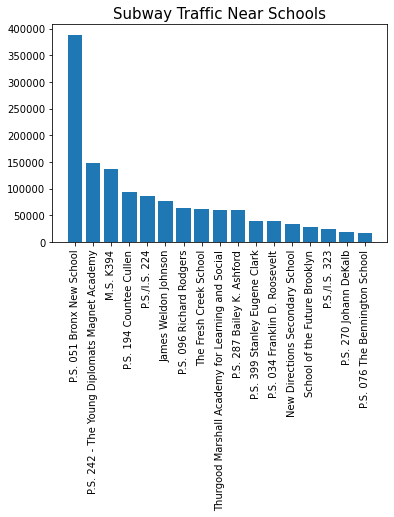

In [148]:
plt.bar(areas_sorted["School Name"], areas_sorted["School Traffic"])
plt.xticks(rotation="vertical")
plt.title("Subway Traffic Near Schools", fontsize=15);

This graph seems to indicate that sending the demonstrations to the station near Public School 051 "Bronx New School" would be the clear choice. However, the station near that school is 42nd St-Port Authority, which is right in front of Times Square. The high amout of subway riders are primarily tourists, not necessarily school children. So, removing that anomaly from the data to get a more accurate visualization: 

In [149]:
areas_sorted = areas_sorted.loc[areas_sorted["School Name"] != "P.S. 051 Bronx New School"]

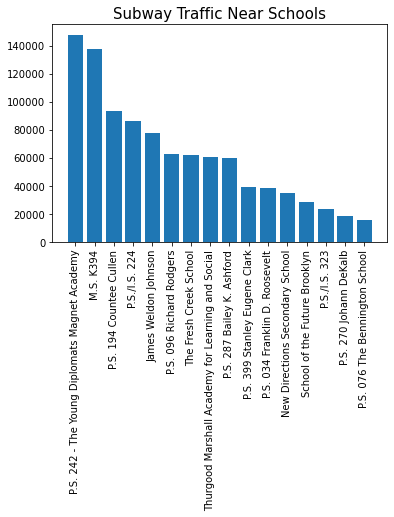

In [150]:
plt.bar(areas_sorted["School Name"], areas_sorted["School Traffic"])
plt.xticks(rotation="vertical")
plt.title("Subway Traffic Near Schools", fontsize=15);

The next 3 highest are P.S. 194 Countee Cullen, P.S. 034 Franklin D. Roosevelt, and Thurgood Marshall, all of which are located in the Harlem area. 

Now, aggregating ridership for each neighborhood, but not combining the schools which fall into "other", as they are not near to one another, and their traffic must be considered separate:

In [151]:
neighborhoods = areas.loc[areas["Neighborhood"] != "other"]
solos = areas.loc[areas["Neighborhood"] == "other"]

In [152]:
neighborhoods = neighborhoods.groupby(["Neighborhood"])[["School Traffic"]].sum()
neighborhoods.reset_index(inplace=True)
neighborhoods.rename(columns={"Neighborhood": "Label"}, inplace=True)

In [153]:
solos = solos.groupby(["School Name"])[["School Traffic"]].sum()
solos.reset_index(inplace=True)
solos.rename(columns={"School Name": "Label"}, inplace=True)

In [154]:
traffic = pd.concat([neighborhoods, solos], axis=0)
traffic_sorted = traffic.sort_values(by="School Traffic", ascending=False)
traffic_sorted

,Label,School Traffic
2,Harlem,465604.0
2,P.S. 051 Bronx New School,388395.0
1,East Brooklyn,251804.0
0,East Bronx,78781.0
4,P.S. 287 Bailey K. Ashford,59548.0
5,P.S. 399 Stanley Eugene Clark,39292.0
1,P.S. 034 Franklin D. Roosevelt,38513.0
0,New Directions Secondary School,34523.0
3,P.S. 270 Johann DeKalb,18718.0


Visualizing this: 

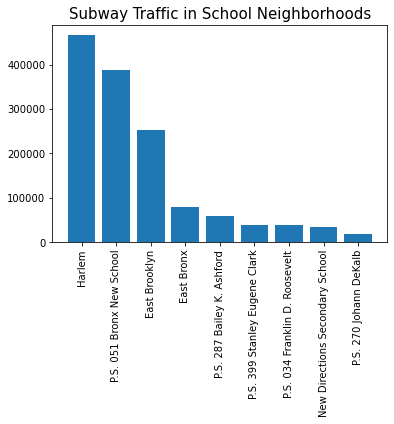

In [186]:
plt.bar(traffic_sorted["Label"], traffic_sorted["School Traffic"])
plt.xticks(rotation="vertical")
plt.title("Subway Traffic in School Neighborhoods", size=15);

This graph demonstrates that Harlem has by far the most riders, greater even than there were total riders at the Times Square station (P.S. 051) in 3 months. 

In choosing where to strategically place the science demonstrations, the obvious choice is amongst the schools in Harlem, or perhaps somewhere amongst those in East Brooklyn, in order to get the most foot-traffic with the greatest combined number of students.  

Between those two areas, Harlem has a great deal more weekday afternoon riders than East Brooklyn does, and furthermore as seen on the maps above, the schools are much closer together in Harlem, which would lead to a higher density of foot traffic, especially by kids after school travelling to the various nearby stations to get home. 

The number of total riders counted and demonstrated on the bar graph above is of course not entirely students, but the close proximity of the schools to the subway and the high total ridership for the entire NY population are both indicative of high ridership amongst students.

For these reasons, **it is our recommendation to Sunny Futures STEM outreach that they host their event in the Harlem neighborhood.** This maximizes the number of schools whose students will see the demonstrations. 


Then the question becomes where within Harlem is the ideal exact location for the event? 

To analyze each station in the area, first we make one DataFrame for Harlem with all of the stations surrounding the schools. To do this, we join the 1st and 2nd closest station columns into a single column for analysis (especially relevant in Harlem as the top 2 closest stations were often equidistant from the school): 

In [156]:
harlem = areas[areas["Neighborhood"] == "Harlem"]
harlem_st1 = harlem[["School Name", "Station 1", "Traffic 1"]]
harlem_st2 = harlem[["School Name", "Station 2", "Traffic 2"]]

In [157]:
harlem_st1.rename(columns={"Station 1": "Station"}, inplace=True)
harlem_st2.rename(columns={"Station 2": "Station"}, inplace=True)
harlem_st1.rename(columns={"Traffic 1": "Traffic"}, inplace=True)
harlem_st2.rename(columns={"Traffic 2": "Traffic"}, inplace=True)

/Users/anterra/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [158]:
harlem = pd.concat([harlem_st1, harlem_st2])

In [159]:
harlem = harlem.loc[harlem["Traffic"] != 0]
harlem_sorted = harlem.sort_values(by="Traffic", ascending=False, inplace=True)

In [160]:
harlem

,School Name,Station,Traffic
7,P.S. 194 Countee Cullen,145 ST ABCD,91206.0
8,P.S. 242 - The Young Diplomats Magnet Academy,125 ST ACBD,80457.0
6,James Weldon Johnson,116 ST 6,77666.0
8,P.S. 242 - The Young Diplomats Magnet Academy,125 ST 23,67155.0
9,P.S./I.S. 224,BROOK AV 6,45404.0
9,P.S./I.S. 224,3 AV-149 ST 25,40974.0
10,Thurgood Marshall Academy for Learning and Social,135 ST 23,30484.0
10,Thurgood Marshall Academy for Learning and Social,135 ST BC,29794.0
7,P.S. 194 Countee Cullen,145 ST 3,2464.0


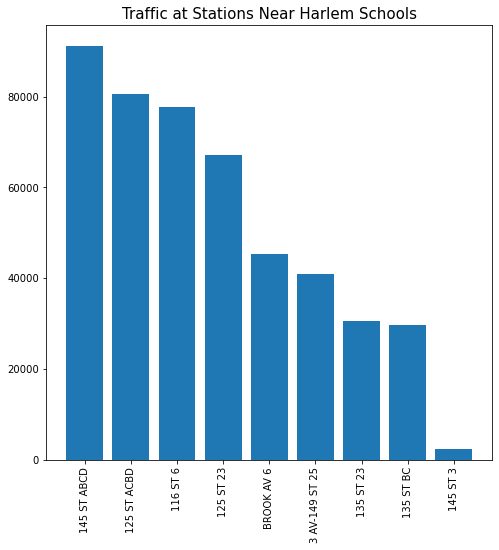

In [189]:
plt.figure(figsize=[8, 8])
plt.bar(harlem["Station"], harlem["Traffic"])
plt.xticks(rotation="vertical")
plt.title("Traffic at Stations Near Harlem Schools", size=15);

The above graph indicates that any of the first 4 stations would be a good choice for the demonstration as they have high afternoon weekday ridership, with up to 1400 riders using the station in a single given afternoon. 

Now, to further choose, it should be taken into consideration what this data actually means in the real world. Many of the stations in Harlem near these particular schools are consecutive stops serving the same lines. To sort by traffic on these lines, we first simplify the above lines listed into labels representing those which are common between more than one station in Harlem: 

In [170]:
lines = ["BC", "BC", "6", "23", "6", "23", "23", "BC", "23"]

In [171]:
harlem["Lines"] = lines
harlem

,School Name,Station,Traffic,Lines
7,P.S. 194 Countee Cullen,145 ST ABCD,91206.0,BC
8,P.S. 242 - The Young Diplomats Magnet Academy,125 ST ACBD,80457.0,BC
6,James Weldon Johnson,116 ST 6,77666.0,6
8,P.S. 242 - The Young Diplomats Magnet Academy,125 ST 23,67155.0,23
9,P.S./I.S. 224,BROOK AV 6,45404.0,6
9,P.S./I.S. 224,3 AV-149 ST 25,40974.0,23
10,Thurgood Marshall Academy for Learning and Social,135 ST 23,30484.0,23
10,Thurgood Marshall Academy for Learning and Social,135 ST BC,29794.0,BC
7,P.S. 194 Countee Cullen,145 ST 3,2464.0,23


In [179]:
harlem_lines = harlem.groupby(["Lines"])[["Station", "Traffic"]].sum()
harlem_lines.reset_index(inplace=True)
harlem_lines.sort_values(by="Traffic", ascending=False, inplace=True)
harlem_lines

,Lines,Traffic
2,BC,201457.0
0,23,141077.0
1,6,123070.0


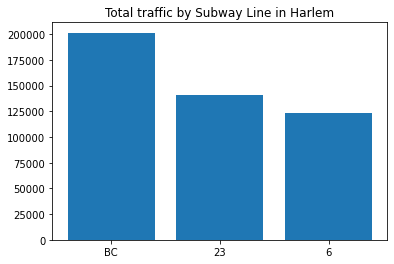

In [180]:
plt.bar(harlem_lines["Lines"], harlem_lines["Traffic"])
plt.title("Total traffic by Subway Line in Harlem");

Stations that service the BC lines have the greatest total traffic, followed by those that service the 23 lines. Reviewing the structure of stations and lines and their proximity to schools on the images below, where schools are flagged in blue and stations are flagged in green, it is clear that as schools are between lines, students may go to either one line or the other depending on where they need to go to get home. 

![map6](https://imgur.com/35eQhOW)

Zooming in to see station labels: 

![map7](https://imgur.com/BF3qfbQ)

## Conclusions

The students at each school will likely disperse either north or south from their school to ride either the BC, 6, or 3 lines (orange/purple, green, and red, respectively), but all of these students from 6 different schools will be riding the same 3 subways, which is significant. 

It would be most advantageous to run the demos at a station with high single-station ridership, as well as one close to several schools in the immediate vicinity. 

Among the stations, 145 St ABCD (farthest north on the map) has the highest single-station ridership for the BC lines, 116 St 6 has the highest traffic for the 6 line, and 125 St 23 has the highest for the 23 lines, reiterated again on the graph below: 

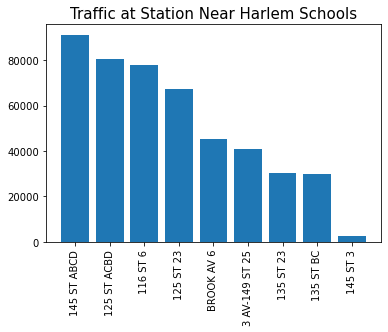

In [181]:
plt.bar(harlem["Station"], harlem["Traffic"])
plt.xticks(rotation="vertical")
plt.title("Traffic at Station Near Harlem Schools", size=15);

For this reason, **we recommend running the demonstration 3 times during the fall semester, at:**
* **145 St Station (lines ABCD)**
* **125 St Station (lines 23)**
* **116 St Station (line 6)**

**To effectively hold one event for all students who ride each subway line home**. In order to get more than just the number of students from the closest school to each station, since kids from many schools will be on the subway going right by those stations, we further recommend **posting flyers at each of the preceding stations** a week before the event to advertise and offer free pizza to incentivize the kids, stating that they only need to ride their usual subway up 1-2 stops for the fun science fair. This also separates the 3 events into north, central, and south, such that students walking by from nearby schools may stumble into each one. 

In this way, Sunny Futures STEM Outreach will reach the maximum number of underprivileged students, to engage them with science! 